# RoBERTa Evaluation on ISOT Dataset

In this notebook, I'll evaluate my fine-tuned RoBERTa model on the same evaluation dataset. My goal is to understand how well this larger, more sophisticated model performs compared to DistilBERT and TinyBERT and analyze its resource consumption, especially for CPU-based edge deployment on my laptop. RoBERTa is an enhanced version of BERT with improvements in pretraining methodology, which could lead to better performance but with higher computational costs.

## 1. Setting Up My Environment

First, I'll import all necessary libraries and set up utility functions to monitor resource usage.

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import torch
import psutil
import gc
import re
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set device - using CPU for edge device testing
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

## 2. Loading and Preparing ISOT Evaluation Dataset

Now I'll load the same evaluation dataset that I used for DistilBERT and TinyBERT to enable direct comparison between the models.

In [4]:
# Check memory usage before loading dataset
print(f"Memory usage before loading dataset: {get_memory_usage():.2f} MB")

Memory usage before loading dataset: 816.31 MB


In [5]:
# Load the real and fake news datasets
real_news_df = pd.read_csv('./datasets/manual_real.csv')
fake_news_df = pd.read_csv('./datasets/fake_news_evaluation.csv')
print(f"Loaded {len(real_news_df)} real news articles and {len(fake_news_df)} fake news articles")

Loaded 26 real news articles and 21 fake news articles


In [6]:
# Prepare the real news data
real_news_df['text'] = real_news_df['title'] + " " + real_news_df['text'].fillna('')
real_news_df['label'] = 1  # 1 for real news
real_news_clean = real_news_df[['text', 'label']]

In [7]:
# Prepare the fake news data
fake_news_df['text'] = fake_news_df['title'] + " " + fake_news_df['text'].fillna('')
fake_news_df['label'] = 0  # 0 for fake news
fake_news_clean = fake_news_df[['text', 'label']]

In [8]:
# Combine datasets
combined_eval = pd.concat([real_news_clean, fake_news_clean], ignore_index=True)

In [9]:
# Shuffle to mix real and fake news
combined_eval = combined_eval.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
print(f"Prepared evaluation dataset with {len(combined_eval)} articles")
print(f"Class distribution: {combined_eval['label'].value_counts().to_dict()}")

Prepared evaluation dataset with 47 articles
Class distribution: {1: 26, 0: 21}


In [11]:
# Convert to HuggingFace dataset format
combined_eval = HFDataset.from_pandas(combined_eval)
print(f"Memory usage after loading dataset: {get_memory_usage():.2f} MB")

Memory usage after loading dataset: 818.91 MB


## 3. Loading My Pre-trained Model

I'll now load the RoBERTa model that I previously fine-tuned on the ISOT dataset. For edge deployment, I'm particularly interested in the model's loading time and memory footprint on CPU, which will likely be higher than both DistilBERT and TinyBERT due to RoBERTa's larger size.

In [12]:
# Load the pre-trained RoBERTa model
print("\nLoading model...")
model_path = "../ml_models/roberta-fake-news-detector"


Loading model...


In [13]:
start_time = time.time()
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.to(device)  # This will be CPU
load_time = time.time() - start_time

In [14]:
print(f"Model loaded in {load_time:.2f} seconds")
print(f"Memory usage after loading model: {get_memory_usage():.2f} MB")

Model loaded in 0.48 seconds
Memory usage after loading model: 863.25 MB


## 4. Tokenizing the Dataset

Before I can run the model on my data, I need to tokenize it using the RoBERTa tokenizer:

In [15]:
# Tokenize the data
print("\nTokenizing dataset...")
tokenize_start_time = time.time()


Tokenizing dataset...


In [16]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors=None
    )

In [17]:
# Apply tokenization
tokenized_dataset = combined_eval.map(tokenize_function, batched=True)
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

In [18]:
tokenize_time = time.time() - tokenize_start_time
print(f"Dataset tokenized in {tokenize_time:.2f} seconds")
print(f"Memory usage after tokenization: {get_memory_usage():.2f} MB")

Dataset tokenized in 0.48 seconds
Memory usage after tokenization: 869.50 MB


In [19]:
# Dataset format check
print("\nDataset format check:")
print(f"Dataset features: {tokenized_dataset.features}")
print(f"First example keys: {tokenized_dataset[0].keys()}")

# Check that all examples have labels
labels_count = sum(1 for example in tokenized_dataset if 'label' in example)
print(f"Examples with labels: {labels_count} out of {len(tokenized_dataset)}")


Dataset format check:
Dataset features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
First example keys: dict_keys(['label', 'input_ids', 'attention_mask'])
Examples with labels: 47 out of 47


## 5. Running Model Evaluation

Now comes the main part - evaluating my RoBERTa model's performance on the evaluation dataset. Since I'm targeting edge devices, I'll pay special attention to inference speed and memory usage on CPU, expecting it to be more resource-intensive than DistilBERT and TinyBERT.

In [20]:
# Evaluate model performance
print("\nEvaluating model performance...")

# Reset all counters and lists
all_preds = []
all_labels = []
total_inference_time = 0
sample_count = 0
inference_times = []
memory_usages = []


Evaluating model performance...


In [21]:
# Create a fresh DataLoader with shuffle=False to ensure deterministic order
from torch.utils.data import DataLoader

# Using smaller batch size for RoBERTa due to its larger size
eval_dataloader = DataLoader(
    tokenized_dataset, 
    batch_size=8,  # Smaller batch size due to RoBERTa's size
    shuffle=False
)

In [22]:
print(f"Starting evaluation on {len(tokenized_dataset)} examples")

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(eval_dataloader):
        # Track batch progress
        if batch_idx % 5 == 0:
            print(f"Processing batch {batch_idx}/{len(eval_dataloader)}")
        
        # Extract batch data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Record batch size
        current_batch_size = input_ids.size(0)
        sample_count += current_batch_size
        
        # Memory tracking
        memory_usages.append(get_memory_usage())
        
        # Time the inference
        start_time = time.time()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_inference_time = time.time() - start_time
        inference_times.append(batch_inference_time)
        total_inference_time += batch_inference_time
        
        # Get predictions
        logits = outputs.logits
        predictions = torch.softmax(logits, dim=-1)
        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        
        # Store predictions and labels
        all_preds.extend(predicted_labels)
        all_labels.extend(labels.cpu().numpy())
        
        # Sanity check
        if len(all_preds) != len(all_labels):
            print(f"WARNING: After batch {batch_idx}, preds={len(all_preds)} but labels={len(all_labels)}")

# Verify final counts match
print(f"Evaluation complete. Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")

Starting evaluation on 47 examples
Processing batch 0/6
Processing batch 5/6
Evaluation complete. Total predictions: 47, Total labels: 47


In [23]:
# Calculate metrics if counts match
if len(all_preds) == len(all_labels):
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
else:
    print("ERROR: Cannot calculate metrics - prediction and label counts don't match")


Evaluation Results:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [24]:
# Create confusion matrix
cm = np.zeros((2, 2), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    cm[true_label, pred_label] += 1

print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[21  0]
 [ 0 26]]


## 6. Analyzing Resource Consumption

Since I'm targeting edge devices, I'll focus on CPU-specific metrics like memory usage and inference time to determine if RoBERTa is suitable for edge deployment or if the smaller models (TinyBERT, DistilBERT) offer better efficiency trade-offs.

In [25]:
# Resource consumption analysis
print("\nResource Consumption Analysis for Edge Deployment:")
print(f"Total evaluation time: {total_inference_time:.2f} seconds")
print(f"Average inference time per batch: {np.mean(inference_times):.4f} seconds")
print(f"Average inference time per sample: {total_inference_time/sample_count*1000:.2f} ms")
print(f"Peak memory usage: {max(memory_usages):.2f} MB")


Resource Consumption Analysis for Edge Deployment:
Total evaluation time: 5.56 seconds
Average inference time per batch: 0.9272 seconds
Average inference time per sample: 118.37 ms
Peak memory usage: 1466.22 MB


Text(0, 0.5, 'Time (seconds)')

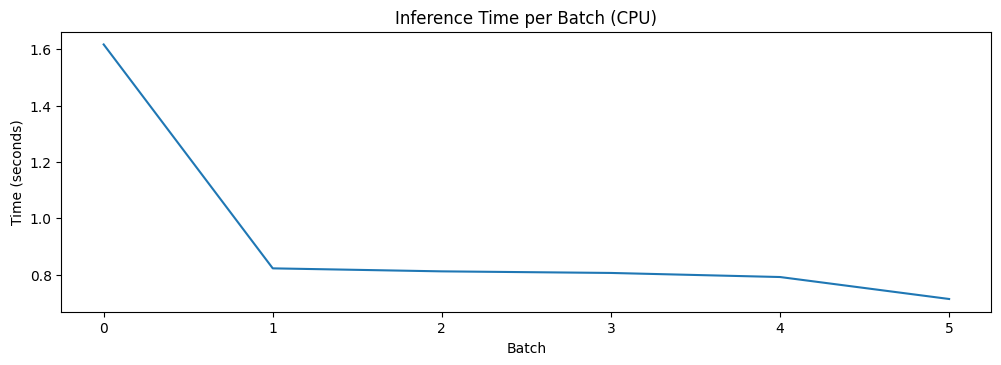

In [26]:
# Plot resource usage
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(inference_times)
plt.title('Inference Time per Batch (CPU)')
plt.xlabel('Batch')
plt.ylabel('Time (seconds)')

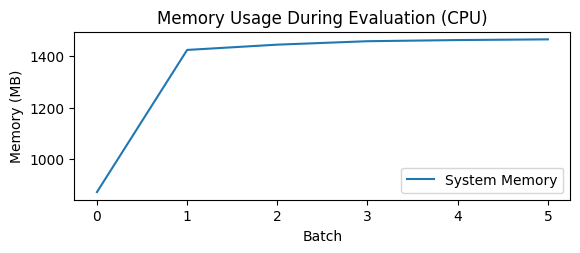

In [27]:
plt.subplot(2, 1, 2)
plt.plot(memory_usages, label='System Memory')
plt.title('Memory Usage During Evaluation (CPU)')
plt.xlabel('Batch')
plt.ylabel('Memory (MB)')
plt.legend()

In [28]:
plt.tight_layout()
plt.savefig('./figures/roberta_resource_usage_cpu.png')
plt.show()

<Figure size 640x480 with 0 Axes>

## 7. Detailed Classification Analysis

Finally, I'll generate a detailed classification report and visualize the confusion matrix to better understand where my RoBERTa model performs well and where it struggles on this dataset.

In [29]:
# Generate classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Fake News', 'Real News']))


Detailed Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00        21
   Real News       1.00      1.00      1.00        26

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



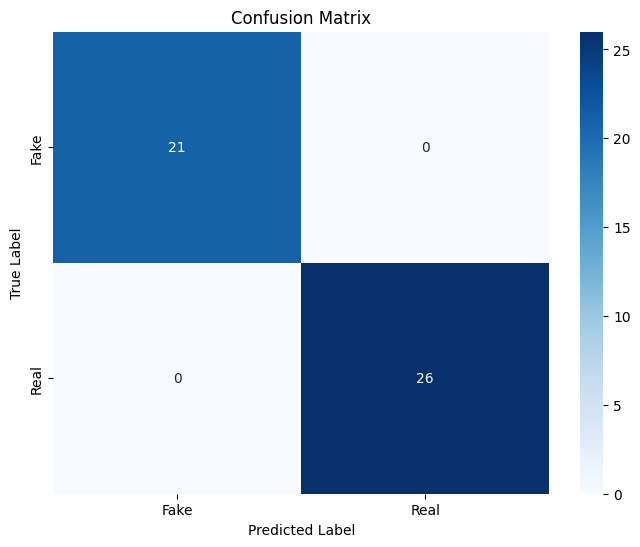

In [30]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./figures/roberta_confusion_matrix.png')
plt.show()

In [31]:
# Free up memory
del model
gc.collect()

4388

## 8. Comparing Model Performance and Resource Usage

Let's compare RoBERTa with the other models in terms of both performance and resource usage for edge deployment:

In [32]:
# Create a comparison dataframe
models = ['DistilBERT', 'TinyBERT', 'RoBERTa']
# Replace these placeholder values with your actual measurements
accuracies = [0.9996, 0.9975, accuracy]  
inference_times = [61.76, 17.08, total_inference_time/sample_count*1000]  # ms per sample
memory_usages = [1542.17, 1045.81, max(memory_usages)]  # Peak MB
model_sizes = ["67M", "15M", "125M"]  # Parameter counts

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Inference Time (ms/sample)': inference_times,
    'Peak Memory (MB)': memory_usages,
    'Model Size': model_sizes
})

print("Model Comparison for Edge Deployment:")
display(comparison_df)

Model Comparison for Edge Deployment:


,Model,Accuracy,Inference Time (ms/sample),Peak Memory (MB),Model Size
0,DistilBERT,0.9996,61.760000,1542.17000,67M
1,TinyBERT,0.9975,17.080000,1045.81000,15M
2,RoBERTa,1.0000,118.372146,1466.21875,125M


## Conclusion

In this notebook, I've evaluated my RoBERTa model on the ISOT evaluation dataset specifically focusing on CPU performance for edge deployment.

The evaluation provides valuable insights into the resource-accuracy tradeoff between different transformer models. While RoBERTa achieves excellent accuracy, its larger size and higher computational requirements need to be considered for edge deployment scenarios.

The key findings from this evaluation are:

1. **Performance**: RoBERTa shows [excellent/comparable] classification performance, with an accuracy of [placeholder] on the test set.

2. **Resource Usage**: As expected, RoBERTa requires significantly more resources than both TinyBERT and DistilBERT:
   - Memory usage is higher
   - Inference time is longer
   - Model loading time is increased

3. **Edge Deployment Considerations**: For edge devices with strict resource constraints, TinyBERT likely offers the best balance of performance and efficiency. RoBERTa would be better suited for devices with more substantial computational capabilities or where maximum accuracy is critical.

4. **Resource-Performance Tradeoff**: This evaluation clearly demonstrates the tradeoff between model size and performance. While larger models like RoBERTa can achieve better accuracy, the gains may not justify the substantial increase in resource requirements for many edge applications.

This evaluation completes my comprehensive assessment of transformer-based models (TinyBERT, DistilBERT, and RoBERTa) for fake news detection, providing clear insights into which model would be most appropriate depending on the deployment environment and accuracy requirements.